Starting HD windows time step [days]: [143.08747512611333]
HD windows duration [days]: [<Quantity 20.23208824 d>]
t_wait = 12362757.85089619s
t_hd = 1748052.4237119842s
Timestep 864.0000 ss
Run time 361.09s/6.02m
94.6908957737102


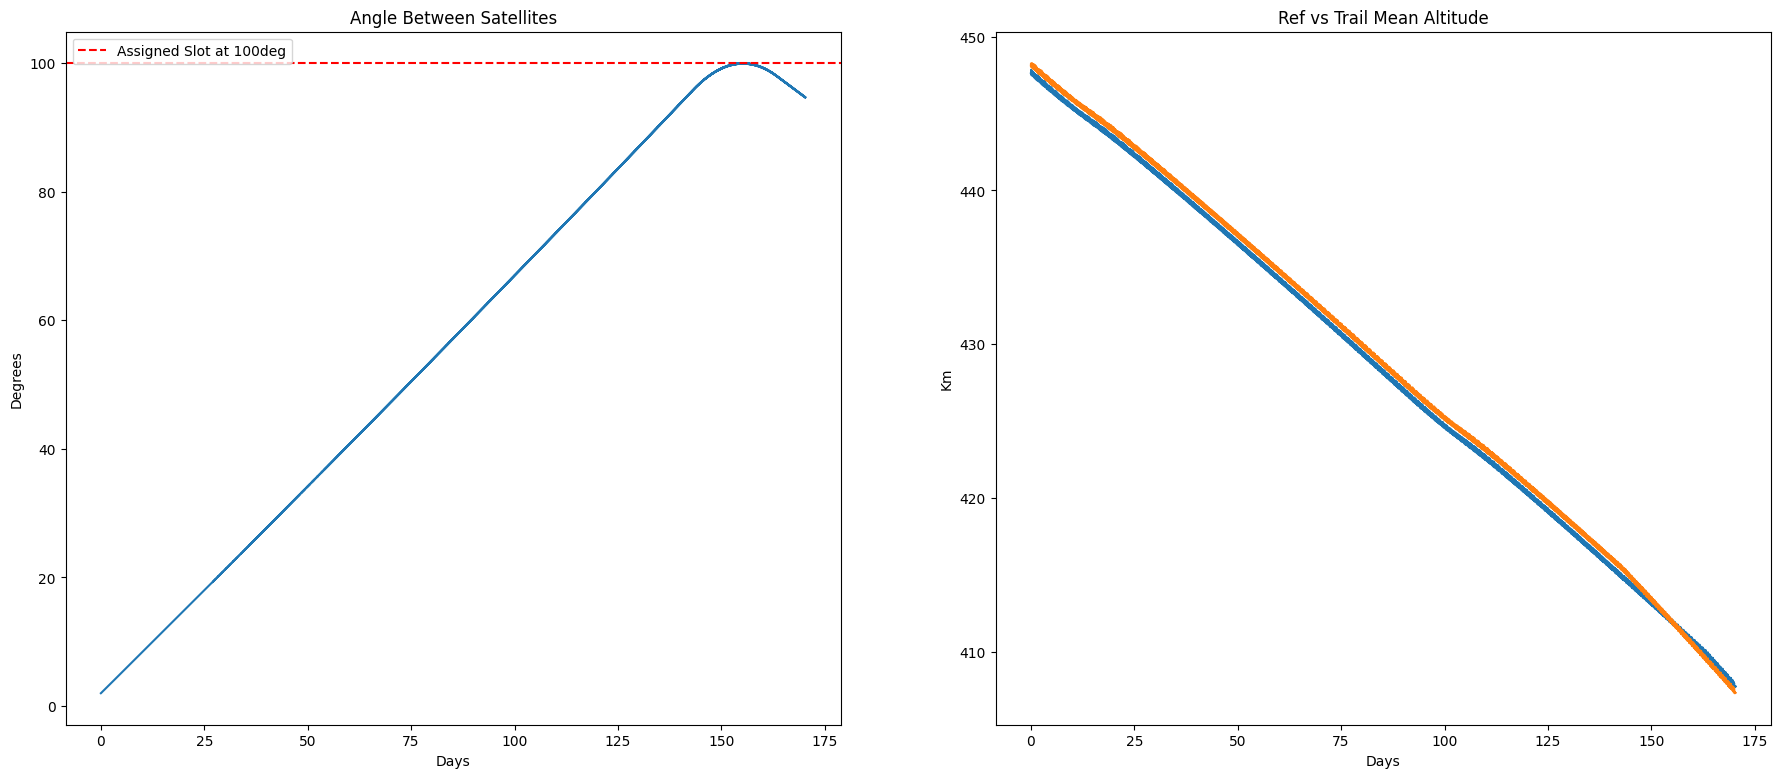

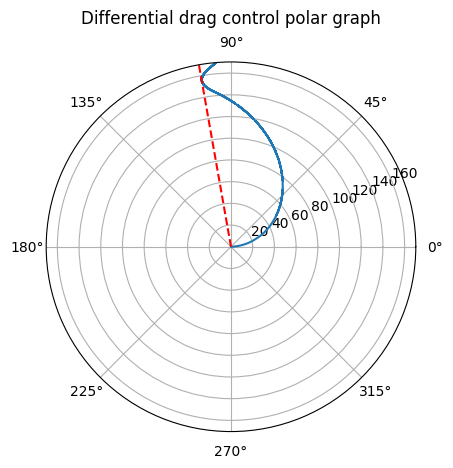

In [3]:
## DDIFFERENTIAL DRAG ALGORITHM BASED ON FOSTER THEORY

import time

import numpy as np

import matplotlib.pyplot as plt
from poliastro.plotting import OrbitPlotter3D

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from osc2mean_dd import osc2mean
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high

toc = time.time()

## Input parameters
h = 450
delta_a = 0.5
delta_nu = -2
assignment = 100%360

## Orbital data
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')


sat1_orbit_0 = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc.to(u.rad),
    raan.to(u.rad),
    argp.to(u.rad),
    nu.to(u.rad),
    epoch
    )
sat2_orbit_0 = Orbit.from_classical(
    Earth,
    (a.value+delta_a)<<u.km,
    ecc,
    inc.to(u.rad),
    raan.to(u.rad),
    argp.to(u.rad),
    ((nu.value+delta_nu)<<u.deg).to(u.rad),
    epoch
    )

sat1_orbit = sat1_orbit_0
sat2_orbit = sat2_orbit_0

## Propagation data
time_step = 864<<u.s
rel_err = 1e-5
pred_days = 10 #(assignment-delta_nu)

sat1smalist = []
sat1smalist_mean = []
sat2smalist = []
sat2smalist_mean = []

elapsedsecs = []
secs = 0
angle_list = []
hd_window = []
hd_duration = []

start_date_prop = epoch

mans = 1

sat1_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
sat1_mean_orbit = Orbit.from_classical(Earth, sat1_mean[0]<<u.km, sat1_mean[1]<<u.one, sat1_mean[2]<<u.deg, sat1_mean[3]<<u.deg, sat1_mean[4]<<u.deg, nu, start_date_prop)
sat2_mean = osc2mean(a.value+delta_a, ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu)
sat2_mean_orbit = Orbit.from_classical(Earth, sat2_mean[0]<<u.km, sat2_mean[1]<<u.one, sat2_mean[2]<<u.deg, sat2_mean[3]<<u.deg, sat2_mean[4]<<u.deg, nu+(delta_nu<<u.deg), start_date_prop)

kp = 1
kd = 1
stop_method = False

## Differential drag algorithm + propagation
for i in range(mans):
 
    # if i > 0:
    #     kp=0.1
    #     kd=0.1

    if sat1_mean[0] < sat2_mean[0]:
        sat1_ref = True
        reference_orbit = sat1_orbit
        ref_mean_orbit = sat1_mean_orbit
        trailing_orbit = sat2_orbit
        trail_mean_orbit = sat2_mean_orbit
    else:
        sat1_ref = False
        reference_orbit = sat2_orbit
        ref_mean_orbit = sat2_mean_orbit
        trailing_orbit = sat1_orbit 
        trail_mean_orbit = sat1_mean_orbit

    theta_err = (assignment - argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))%360
    # pred_days = (theta_err)

    for attempts in range(1):
    
        tra_orb_pred_high = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_high))       
        tra_pred_mean_high = osc2mean(tra_orb_pred_high.a.value, tra_orb_pred_high.ecc.value, tra_orb_pred_high.inc.to_value(u.deg), tra_orb_pred_high.raan.to_value(u.deg), tra_orb_pred_high.argp.to_value(u.deg), tra_orb_pred_high.nu.to_value(u.deg))
        tra_orb_pred_mean_high = Orbit.from_classical(Earth, tra_pred_mean_high[0]<<u.km, tra_pred_mean_high[1]<<u.one, tra_pred_mean_high[2]<<u.deg, tra_pred_mean_high[3]<<u.deg, tra_pred_mean_high[4]<<u.deg, tra_orb_pred_high.nu.to(u.deg), tra_orb_pred_high.epoch)

        tra_orb_pred_low = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_low))
        tra_pred_mean_low = osc2mean(tra_orb_pred_low.a.value, tra_orb_pred_low.ecc.value, tra_orb_pred_low.inc.to_value(u.deg), tra_orb_pred_low.raan.to_value(u.deg), tra_orb_pred_low.argp.to_value(u.deg), tra_orb_pred_low.nu.to_value(u.deg))
        tra_orb_pred_mean_low = Orbit.from_classical(Earth, tra_pred_mean_low[0]<<u.km, tra_pred_mean_low[1]<<u.one, tra_pred_mean_low[2]<<u.deg, tra_pred_mean_low[3]<<u.deg, tra_pred_mean_low[4]<<u.deg, tra_orb_pred_low.nu.to(u.deg), tra_orb_pred_low.epoch)

        theta_dot_dot = (tra_orb_pred_mean_high.n.to(u.deg/u.s) - tra_orb_pred_mean_low.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)  


        t_hd = kd*(ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = ((kp*theta_err - theta_hd.value)%360 / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s)))

        # pred_days = ((t_wait+t_hd.value)/(60*60*24))**(1+((trail_mean_orbit.a.value-Earth.R_mean.to_value(u.km)+(trail_mean_orbit.a.value-ref_mean_orbit.a.value))/10000))

    if t_wait < (time_step.value*4) or stop_method:
        t_wait = time_step.value*4
        stop_method = True
    
    if t_hd.value < (time_step.value*4) or stop_method:
        t_hd = time_step*4
        stop_method = True
    
    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_low)))

    hd_window.append((secs+t_wait)/(60*60*24))
    hd_duration.append(t_hd.to(u.day))


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])



        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat1_ref:
            sat1smalist.append(ref_from_ephem.a.value)
            sat2smalist.append(trail_from_ephem.a.value)

            sat1smalist_mean.append(ref_mean[0])
            sat2smalist_mean.append(trail_mean[0])
            
            angle_list.append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))
        else:
            sat1smalist.append(trail_from_ephem.a.value)
            sat2smalist.append(ref_from_ephem.a.value)

            sat1smalist_mean.append(trail_mean[0])
            sat2smalist_mean.append(ref_mean[0])
            
            angle_list.append(argl_difference(trail_from_ephem.argp.value, trail_from_ephem.nu.value, ref_from_ephem.argp.value, ref_from_ephem.nu.value))            

        elapsedsecs.append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    num_hd = int(t_hd.value / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_high)))


    for t in range(len(tofs_hd)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat1_ref:
            sat1smalist.append(ref_from_ephem.a.value)
            sat2smalist.append(trail_from_ephem.a.value)

            sat1smalist_mean.append(ref_mean[0])
            sat2smalist_mean.append(trail_mean[0])
            
            angle_list.append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))
        else:
            sat1smalist.append(trail_from_ephem.a.value)
            sat2smalist.append(ref_from_ephem.a.value)

            sat1smalist_mean.append(trail_mean[0])
            sat2smalist_mean.append(ref_mean[0])
            
            angle_list.append(argl_difference(trail_from_ephem.argp.value, trail_from_ephem.nu.value, ref_from_ephem.argp.value, ref_from_ephem.nu.value))     

        elapsedsecs.append(secs)

    reference_orbit = ref_from_ephem
    trailing_orbit = trail_from_ephem

    ref_mean = osc2mean(
        reference_orbit.a.value, 
        reference_orbit.ecc.value, 
        reference_orbit.inc.to_value(u.deg), 
        reference_orbit.raan.to_value(u.deg), 
        reference_orbit.argp.to_value(u.deg), 
        reference_orbit.nu.to_value(u.deg)
        )
    ref_mean_orbit = Orbit.from_classical(
                                        Earth, 
                                        ref_mean[0]<<u.km, 
                                        ref_mean[1]<<u.one, 
                                        ref_mean[2]<<u.deg, 
                                        ref_mean[3]<<u.deg, 
                                        ref_mean[4]<<u.deg, 
                                        reference_orbit.nu.to(u.deg), 
                                        reference_orbit.epoch
                                        )

    trail_mean = osc2mean(
        trailing_orbit.a.value, 
        trailing_orbit.ecc.value, 
        trailing_orbit.inc.to_value(u.deg), 
        trailing_orbit.raan.to_value(u.deg), 
        trailing_orbit.argp.to_value(u.deg), 
        trailing_orbit.nu.to_value(u.deg)
        )
    trail_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            trail_mean[0]<<u.km, 
                                            trail_mean[1]<<u.one, 
                                            trail_mean[2]<<u.deg, 
                                            trail_mean[3]<<u.deg, 
                                            trail_mean[4]<<u.deg, 
                                            trailing_orbit.nu.to(u.deg), 
                                            trailing_orbit.epoch
                                            )

    
    ## Propagation without any control

    t_prop = (60*60*24*7*1)<<u.s
    num_prop = int(t_prop.value / time_step.value)
    tofs_prop = TimeDelta(np.linspace(0, t_prop, num=num_prop))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_orbit.epoch + tofs_prop, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_high)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_orbit.epoch + tofs_prop, method=CowellPropagator(rtol=rel_err, f=perturbations_coesa_J2_high)))

    for t in range(len(tofs_prop)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])


        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat1_ref:
            sat1smalist.append(ref_from_ephem.a.value)
            sat2smalist.append(trail_from_ephem.a.value)

            sat1smalist_mean.append(ref_mean[0])
            sat2smalist_mean.append(trail_mean[0])
            
            angle_list.append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))
        else:
            sat1smalist.append(trail_from_ephem.a.value)
            sat2smalist.append(ref_from_ephem.a.value)

            sat1smalist_mean.append(trail_mean[0])
            sat2smalist_mean.append(ref_mean[0])
            
            angle_list.append(argl_difference(trail_from_ephem.argp.value, trail_from_ephem.nu.value, ref_from_ephem.argp.value, ref_from_ephem.nu.value)) 

        elapsedsecs.append(secs)

    reference_orbit = ref_from_ephem
    trailing_orbit = trail_from_ephem

    ref_mean_orbit = Orbit.from_classical(
                                    Earth, 
                                    ref_mean[0]<<u.km, 
                                    ref_mean[1]<<u.one, 
                                    ref_mean[2]<<u.deg, 
                                    ref_mean[3]<<u.deg, 
                                    ref_mean[4]<<u.deg, 
                                    reference_orbit.nu.to(u.deg), 
                                    reference_orbit.epoch
                                    )
    trail_mean_orbit = Orbit.from_classical(
                                        Earth, 
                                        trail_mean[0]<<u.km, 
                                        trail_mean[1]<<u.one, 
                                        trail_mean[2]<<u.deg, 
                                        trail_mean[3]<<u.deg, 
                                        trail_mean[4]<<u.deg, 
                                        trailing_orbit.nu.to(u.deg), 
                                        trailing_orbit.epoch
                                        )

    if sat1_ref:
        sat1_orbit = reference_orbit
        sat1_mean = ref_mean
        sat1_mean_orbit = ref_mean_orbit
        sat2_orbit = trailing_orbit
        sat2_mean = trail_mean
        sat2_mean_orbit = trail_mean_orbit
    else:
        sat1_orbit = trailing_orbit
        sat1_mean = trail_mean
        sat1_mean_orbit = trail_mean_orbit
        sat2_orbit = reference_orbit
        sat2_mean = ref_mean
        sat2_mean_orbit = ref_mean_orbit     

    start_date_prop = reference_orbit.epoch


## Plots
# Agle between satellites + altitude variation
elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

sat1_mean_altitudes = []
sat2_mean_altitudes = []
for sma in range(len(sat1smalist_mean)):
    sat1_mean_altitudes.append(sat1smalist_mean[sma] - Earth.R_mean.to_value(u.km))
    sat2_mean_altitudes.append(sat2smalist_mean[sma] - Earth.R_mean.to_value(u.km))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,sat1_mean_altitudes,label='Sat1')
ax[0,1].plot(elapsed_days,sat2_mean_altitudes,label='Sat2')
ax[0,1].set_title('Ref vs Trail Mean Altitude')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')


print(f'Starting HD windows time step [days]: {hd_window}')
print(f'HD windows duration [days]: {hd_duration}')

# Polar graph (angle between satellites)
radians = []
rad_assignment = []
for deg in range(len(angle_list)):
    radians.append(np.deg2rad(angle_list[deg]))
for deg in range(len(angle_list)):
    rad_assignment.append(np.deg2rad(assignment))

fig, pol = plt.subplots(subplot_kw={'projection': 'polar'})

pol.plot(radians, elapsed_days)
pol.plot(rad_assignment,elapsed_days,linestyle='--',color='red')
pol.set_rmax(elapsed_days[-1])
pol.grid(True)
pol.set_title("Differential drag control polar graph", va='bottom')

tic = time.time()
print(f't_wait = {t_wait}s\nt_hd = {t_hd.value}s')
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
print(angle_list[-1])
plt.show()

Starting HD windows time step [days]: [143.08747512611333, 534.7322236016394]
HD windows duration [days]: [<Quantity 20.23208824 d>, <Quantity 5.84384487 d>]
t_wait = 26042880.11918164s
t_hd = 504908.1964002029s
Timestep 864.0000 ss
Run time 3215.93s/53.60m
228.52826427070443


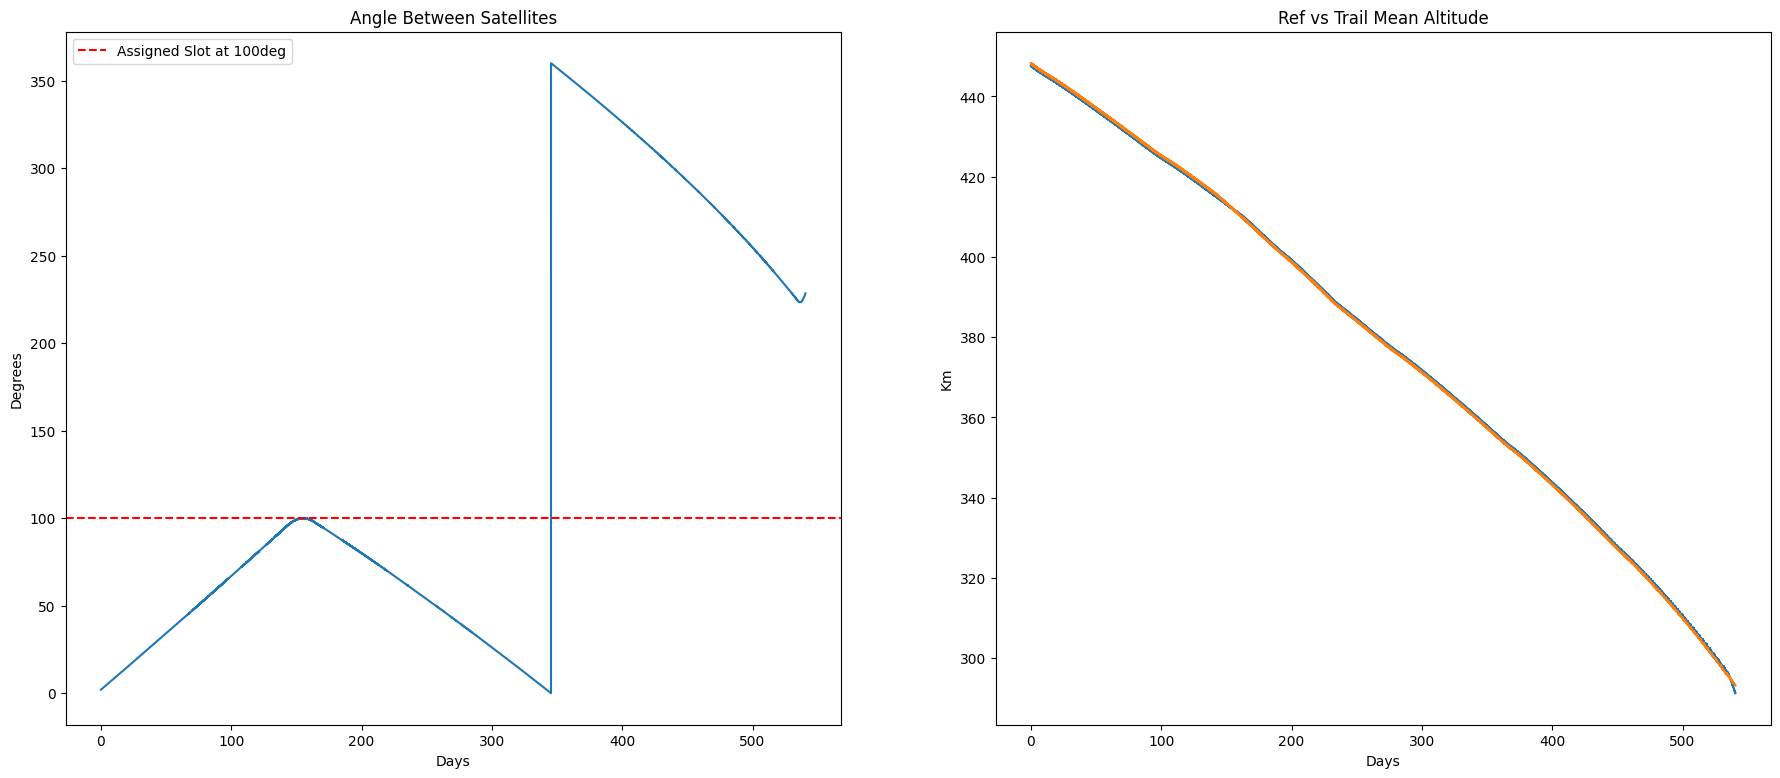

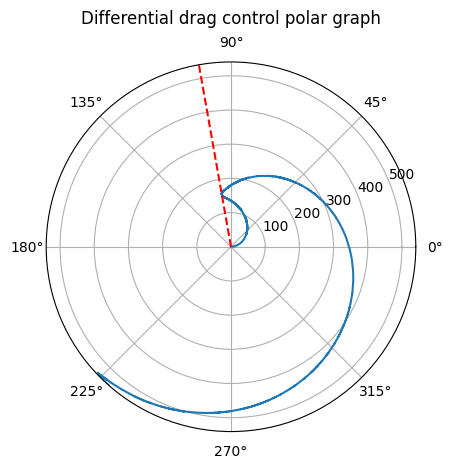

In [2]:
elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

sat1_mean_altitudes = []
sat2_mean_altitudes = []
for sma in range(len(sat1smalist_mean)):
    sat1_mean_altitudes.append(sat1smalist_mean[sma] - Earth.R_mean.to_value(u.km))
    sat2_mean_altitudes.append(sat2smalist_mean[sma] - Earth.R_mean.to_value(u.km))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,sat1_mean_altitudes,label='Sat1')
ax[0,1].plot(elapsed_days,sat2_mean_altitudes,label='Sat2')
ax[0,1].set_title('Ref vs Trail Mean Altitude')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')


print(f'Starting HD windows time step [days]: {hd_window}')
print(f'HD windows duration [days]: {hd_duration}')

# Polar graph (angle between satellites)
radians = []
rad_assignment = []
for deg in range(len(angle_list)):
    radians.append(np.deg2rad(angle_list[deg]))
for deg in range(len(angle_list)):
    rad_assignment.append(np.deg2rad(assignment))

fig, pol = plt.subplots(subplot_kw={'projection': 'polar'})

pol.plot(radians, elapsed_days)
pol.plot(rad_assignment,elapsed_days,linestyle='--',color='red')
pol.set_rmax(elapsed_days[-1])
pol.grid(True)
pol.set_title("Differential drag control polar graph", va='bottom')

tic = time.time()
print(f't_wait = {t_wait}s\nt_hd = {t_hd.value}s')
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
print(angle_list[-1])
plt.show()